# Pruning

In [253]:
import torch.nn.utils.prune as prune
import torch
import torchvision.transforms
from torchvision import datasets, transforms
from torch import nn
from typing import Optional, List, Tuple, Union

from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

import math
import warnings

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules.module import Module
from torch.nn.modules.utils import _single, _pair, _triple, _reverse_repeat_tuple
from torch._torch_docs import reproducibility_notes

from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from typing import Optional, List, Tuple, Union

import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

# own module
from visualisation.feature_map import *

import random


mode = "l1"

['../helper', './helper', '/helper', 'helper', 'C:\\Users\\Prinzessin\\projects\\decentnet\\datasceyence\\examples', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\python39.zip', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\DLLs', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta', '', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Prinzessin\\anaconda3\\envs\\feta\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Prinzessin\\.ipython']


In [262]:
class _ConvNd(torch.nn.Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
        ...

    in_channels: int
    _reversed_padding_repeated_twice: List[int]
    out_channels: int
    kernel_size: Tuple[int, ...]
    stride: Tuple[int, ...]
    padding: Union[str, Tuple[int, ...]]
    dilation: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: Tensor
    bias: Optional[Tensor]

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, ...],
                 stride: Tuple[int, ...],
                 padding: Tuple[int, ...],
                 dilation: Tuple[int, ...],
                 transposed: bool,
                 output_padding: Tuple[int, ...],
                 groups: int,
                 bias: bool,
                 padding_mode: str,
                 device=None,
                 dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        print(factory_kwargs)
        super().__init__()
        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")

        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        # `_reversed_padding_repeated_twice` is the padding to be passed to
        # `F.pad` if needed (e.g., for non-zero padding types that are
        # implemented as two ops: padding + conv). `F.pad` accepts paddings in
        # reverse order than the dimension.
        if isinstance(self.padding, str):
            self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
            if padding == 'same':
                for d, k, i in zip(dilation, kernel_size,
                                   range(len(kernel_size) - 1, -1, -1)):
                    total_padding = d * (k - 1)
                    left_pad = total_padding // 2
                    self._reversed_padding_repeated_twice[2 * i] = left_pad
                    self._reversed_padding_repeated_twice[2 * i + 1] = (
                        total_padding - left_pad)
        else:
            self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

        if transposed:
            self.weight = Parameter(torch.empty(
                (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
            self.importance = Parameter(torch.empty(
                (in_channels, out_channels // groups), **factory_kwargs))
            
        else:
            self.weight = Parameter(torch.empty(
                (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
            self.importance = Parameter(torch.empty(
                (out_channels, in_channels // groups), **factory_kwargs))
            
        if bias:
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()


class CustomConv2d(_ConvNd):
    
    # additionally needed
    """
    
    position
    activated channels
    connection between channels
    
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)
        
        # this layer id
        layer_id = 0
        
        # within this layer, a whole filter can be deactivated
        # within a filter, single channels can be deactivated
        # within this layer, filters can be swapped

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super().__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        
        # this is written in c++ - try not to change ...
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)



In [263]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = CustomConv2d(1, 32, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv2 = CustomConv2d(32, 64, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv3 = CustomConv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv1x1 = CustomConv2d(128, 10, kernel_size=1, stride=1, padding=0, dilation=1)
        
        self.K = 100 
        self.L = 10 # last one
        self.num_of_bases = 1 # 3rd dim
        
        if False:
            self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv3 = Conv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation=3)
            self.conv1x1 = Conv2d(128, 10, kernel_size=1, stride=1, padding=0, dilation=1)
        #self.dropout1 = nn.Dropout(0.25)
        #self.dropout2 = nn.Dropout(0.5)
        # 4x16384
        # self.fc1 = nn.Linear(10*10*10, 10)
        #self.fc2 = nn.Linear(10, 10)
        
        #self.flat = nn.Flatten()
        
        self.fc3 = nn.Linear(10, 10)
        
        self.mish1 = torch.nn.Mish()
        self.mish2 = torch.nn.Mish()
        self.mish3 = torch.nn.Mish()
        self.mish1x1 = torch.nn.Mish()
        
        #self.sub_concept_pooling = nn.modules.MaxPool2d((self.K, 1), stride=(1,1))
        #self.instance_pooling = nn.modules.MaxPool2d((opt.num_of_bases, 1), stride=(1,1))
        
        self.flat = nn.Flatten()
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.mish1(x)
        
        x = self.conv2(x)
        x = self.mish2(x)
        
        x = self.conv3(x)
        x = self.mish3(x)
        
        x = self.conv1x1(x)
        x = self.mish1x1(x)
        
        # print(x.shape)
        
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        
        #print(x.size())
        #print(x.size()[2:])
        
        x = F.avg_pool2d(x, kernel_size=x.size()[2:])
        
        x = x.reshape(x.size(0), -1)
        x = self.fc3(x)
        
        # x = self.flat(x)
        
        #x = self.fc2(x)
        
        
        #x = x.view(-1, self.L, self.K, 10)
        
        # input, kernel_size, stride, padding, dilation, ceil_mode
        #x = self.sub_concept_pooling(x).view(-1, self.L, self.num_of_bases).permute(0,2,1).unsqueeze(1)
        
        # output = F.sigmoid(x)
        # x = x.reshape(x.size(0), -1)
        
        #x = torch.flatten(x, 1)
        # x = self.fc1(x)
        #x = F.relu(x)
        
        #x = self.dropout2(x)
        #x = self.fc2(x)
        #output = F.log_softmax(x, dim=1)
        
        x = self.sigmoid(x)
        
        return x





In [269]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        
        
        data, target = data.to(device), target.unsqueeze(1) # .to(device)
        optimizer.zero_grad()
        output = model(data)
        
        target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
        
        if batch_idx == -1:
            print(data.shape) # torch.Size([4, 1, 28, 28])
            print(target)
            """
            tensor([[8],
            [7],
            [2],
            [7]])
            """
            print(target_multi_hot)
            """
            tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
            [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
            """
        
        loss = F.binary_cross_entropy(output, target_multi_hot)
        loss.backward()
        optimizer.step()
        if batch_idx % (args.log_interval*1000) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            


def test(args, model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.unsqueeze(1) # .to(device)
            
            output = model(data)
            
            target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
            test_loss += F.binary_cross_entropy(output, target_multi_hot, reduction='mean').item()
        
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.to(device).view_as(pred)).sum().item()
            
            """
            if i == 0 and epoch % args.log_interval == 0:
            # if False: # i == 0:
                print(data.shape)
                layer = model.conv1x1 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv
                # run feature map
                dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
                dd.run(data)
                dd.plot(path=f"example_results/feature_map_{epoch}.png")
                """

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

class Parser():
    def __init__(self):
        self.batch_size = 128
        self.test_batch_size = 1
        self.epochs = 100
        self.lr = 0.1
        self.gamma = 0.7
        self.log_interval = 5
        self.save_model = True
        

def main_train():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('example_data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('example_data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr)

    #scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader, epoch)
        #scheduler.step()
        
        
        if args.save_model and epoch % args.log_interval == 0:
            torch.save(model.state_dict(), f"example_results/mnist_cnn_{epoch}.ckpt")


def main_test():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        test_kwargs.update(cuda_kwargs)

    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset2 = datasets.MNIST('example_data', train=False,
                       transform=transform)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)

    if True:
        model.load_state_dict(torch.load("example_results/mnist_cnn_5.ckpt"))
    else:
        model.load_state_dict(torch.load("example_results/pruned_model.ckpt"))
    

    # model = torch.load(model.state_dict(), "example_results/mnist_cnn_30.ckpt")
    #est(args, model, device, test_loader, 0)
    
    return model
        
    
            


In [270]:
model_to_prune = main_test()

{'device': None, 'dtype': None}
{'device': None, 'dtype': None}
{'device': None, 'dtype': None}
{'device': None, 'dtype': None}


In [271]:
if mode == "l1":
    prune.l1_unstructured(model_to_prune.conv2, name="weight", amount=0.7)

In [272]:
if mode == "random":
    prune.random_unstructured(model_to_prune.conv2, name="weight", amount=0.7)

In [273]:
print(model_to_prune.conv2._forward_pre_hooks)

OrderedDict([(0, <torch.nn.utils.prune.L1Unstructured object at 0x00000211B4F731F0>)])


In [274]:
prune.remove(model_to_prune.conv2, "weight")

CustomConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), dilation=(3, 3))

In [275]:
torch.save(model_to_prune.state_dict(), f"example_results/pruned_model.ckpt")

In [276]:
print(model_to_prune.conv2.weight.shape)

torch.Size([64, 32, 3, 3])


In [277]:
print(model_to_prune.conv2.weight.shape)

torch.Size([64, 32, 3, 3])


In [285]:
torch.set_printoptions(profile="full")

tmp = model_to_prune.conv2.weight.to_sparse() # .indices()

In [279]:
# Visualisation

In [286]:
model = model_to_prune

torch.Size([64, 32, 3, 3])


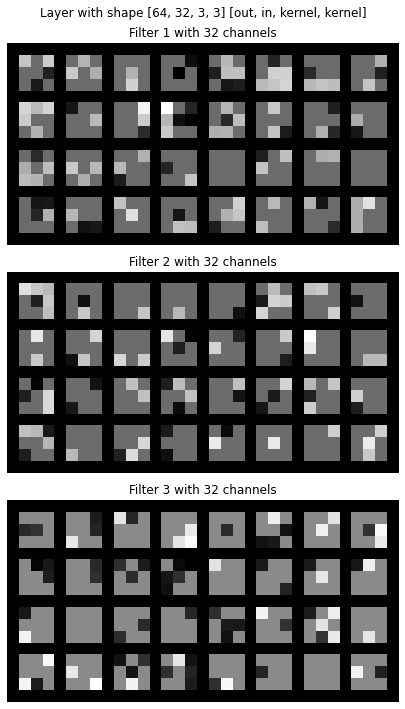

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import utils

def visChannels(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    
    plt.figure(figsize=(nrow,rows) )
    plt.title(f"Channels with index {ch}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))


def visFilters(tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.title(f"Filter {filt}")
    plt.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))

def visFilters_subplot(subplot, tensor, filt=0, allkernels=False, nrow=8, padding=1): 
    f,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(f*c, -1, w, h)
    elif f != 3: tensor = tensor[filt,:,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    # plt.figure( figsize=(nrow,rows) )
    subplot.set_title(f"Filter {filt+1} with {c} channels")
    subplot.imshow(grid.detach().cpu().numpy().transpose((1, 2, 0)))
    subplot.axis('off')
    
layer = 1
filter = model.conv2.weight.data.clone()

print(model.conv2.weight.shape)

# need to match the network parameters!!!!
in_channels = 5
out_filters = 3 # 64


fig, subplot = plt.subplots(out_filters, figsize=(10, 10))
fig.suptitle(f'Layer with shape {list(model.conv2.weight.shape)} [out, in, kernel, kernel]')

for filt in range(0, out_filters):
    
    visFilters_subplot(subplot[filt], filter, filt=filt, allkernels=False)

    #plt.axis('off')
    #plt.ioff()
    
plt.tight_layout()
plt.savefig(f"example_results/filter_with_weights.png")
plt.show()
    
if False:    
    for filt in range(0, out_filters):

        visFilters(filter, filt=filt, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.tight_layout()
        #plt.savefig(f"examples/example_results/filter_with_weights.png")
        plt.show()

    for ch in range(0, in_channels):

        visChannels(filter, ch=ch, allkernels=False)

        plt.axis('off')
        plt.ioff()
        plt.show()

# Magnitude as importance score

In [289]:
# program to compute magnitude of a vector
 
# importing required libraries
import numpy
import math
 
# function definition to compute magnitude o f the vector
def magnitude(vector): 
    return math.sqrt(sum(pow(element, 2) for element in vector))

 
# displaying the original vector
v = numpy.array([0, 1, 2, 3, 4])
print('Vector:', v)
 
# computing and displaying the magnitude of the vector
print('Magnitude of the Vector:', magnitude(v))


Vector: [0 1 2 3 4]
Magnitude of the Vector: 5.477225575051661


****************************************
****************************************
****************************************
****************************************
****************************************
****************************************


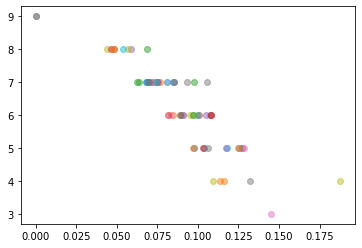

In [298]:

for i_f, f in enumerate(filter):
    

    l1_norm = f[1].abs().sum().detach().cpu().numpy()
    l2_norm = f[1].norm(2).detach().cpu().numpy()
    mag = math.sqrt(sum(pow(f[1].flatten(), 2)))
    
    m = magnitude(f[1].flatten())
    z = np.count_nonzero(np.abs(f[1].detach().cpu().numpy())==0.0)
    
    if False:
        print()
        print(i_f)
        print(f[1].shape)

        print(l2_norm)
        print(f[1])

        print(z)
    
    if m > 0.1 and z > 5:
        print("*" * 40)
    
    plt.scatter(mag, z, alpha=0.5)

plt.show()
        
    

In [ ]:
np.abs(f[1].detach().cpu().numpy())==0.0

# L1

In [ ]:
import torch
import torch.nn as nn

# Example: Define a simple neural network
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.conv = nn.Conv2d(100,10,(3,3))
        self.fc = nn.Linear(10, 5)

model = SimpleModel()

# Access the parameters (weights) of the model
params = list(model.parameters())

weight = torch.rand(3, 3)

# Calculate L1 norm
l1_norm = weight.abs().sum()

# Calculate L2 norm
l2_norm = weight.norm(2)

mag = math.sqrt(sum(pow(weight.flatten(), 2)))

print("L1 Norm:", l1_norm.item())
print("L2 Norm:", l2_norm.item())
print("magnitude:", mag)

In [ ]:
for p in params:
    print(p.shape)

# L1 unstructured and Ln structured pruning

In [ ]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune

m = nn.Linear(10,1,bias=False)
m

In [79]:
data = torch.arange(10).float()
data = torch.randperm(50).float()[:10]
data

tensor([47.,  9., 31., 32., 48., 16., 38., 28., 29., 46.])

In [80]:
m.weight = nn.Parameter(data)
m.weight

Parameter containing:
tensor([47.,  9., 31., 32., 48., 16., 38., 28., 29., 46.], requires_grad=True)

In [81]:
prune.l1_unstructured(m, 'weight', .3) # prune lowest 30 percent, aka 3 values
m.weight

tensor([47.,  0., 31., 32., 48.,  0., 38.,  0., 29., 46.],
       grad_fn=<MulBackward0>)

In [105]:
c = nn.Conv2d(4, 3, 2)
c.weight

Parameter containing:
tensor([[[[-0.0900,  0.2500],
          [-0.2184, -0.0167]],

         [[ 0.0215,  0.1768],
          [-0.1058,  0.1643]],

         [[-0.2095, -0.2312],
          [-0.1659,  0.2375]],

         [[ 0.2153,  0.2165],
          [ 0.2357, -0.2218]]],


        [[[ 0.0665, -0.2468],
          [ 0.0473,  0.1049]],

         [[ 0.2415, -0.0008],
          [-0.1689,  0.1381]],

         [[ 0.1242,  0.2478],
          [ 0.2110,  0.2438]],

         [[ 0.0061, -0.0929],
          [ 0.1407, -0.0912]]],


        [[[-0.1477, -0.0976],
          [-0.2365,  0.1050]],

         [[ 0.1973,  0.2303],
          [ 0.1177,  0.2101]],

         [[-0.2278, -0.1134],
          [ 0.2372, -0.1012]],

         [[ 0.1795,  0.1624],
          [ 0.1832,  0.1367]]]], requires_grad=True)

In [106]:
from torch.nn.utils import prune
m = prune.ln_structured(
    c, 'weight', amount=0.6, dim=1, n=float('-inf')
)

In [107]:
m.weight

tensor([[[[-0.0900,  0.2500],
          [-0.2184, -0.0167]],

         [[ 0.0000,  0.0000],
          [-0.0000,  0.0000]],

         [[-0.2095, -0.2312],
          [-0.1659,  0.2375]],

         [[ 0.0000,  0.0000],
          [ 0.0000, -0.0000]]],


        [[[ 0.0665, -0.2468],
          [ 0.0473,  0.1049]],

         [[ 0.0000, -0.0000],
          [-0.0000,  0.0000]],

         [[ 0.1242,  0.2478],
          [ 0.2110,  0.2438]],

         [[ 0.0000, -0.0000],
          [ 0.0000, -0.0000]]],


        [[[-0.1477, -0.0976],
          [-0.2365,  0.1050]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[-0.2278, -0.1134],
          [ 0.2372, -0.1012]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]]], grad_fn=<MulBackward0>)

In [108]:
m.weight

tensor([[[[-0.0900,  0.2500],
          [-0.2184, -0.0167]],

         [[ 0.0000,  0.0000],
          [-0.0000,  0.0000]],

         [[-0.2095, -0.2312],
          [-0.1659,  0.2375]],

         [[ 0.0000,  0.0000],
          [ 0.0000, -0.0000]]],


        [[[ 0.0665, -0.2468],
          [ 0.0473,  0.1049]],

         [[ 0.0000, -0.0000],
          [-0.0000,  0.0000]],

         [[ 0.1242,  0.2478],
          [ 0.2110,  0.2438]],

         [[ 0.0000, -0.0000],
          [ 0.0000, -0.0000]]],


        [[[-0.1477, -0.0976],
          [-0.2365,  0.1050]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]],

         [[-0.2278, -0.1134],
          [ 0.2372, -0.1012]],

         [[ 0.0000,  0.0000],
          [ 0.0000,  0.0000]]]], grad_fn=<MulBackward0>)

# connection cost calculation

In [116]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# Example: One point and many points
def calc_distances(m,n,ms,ns):
    mn = np.array((m,n)) 

    msns = np.array((ms, ns)).transpose(1,0)
    # print(msns)
    
    list = []

    # Calculate Euclidean distances
    distances = cdist([mn], msns, 'euclidean')
    #print("euclidean distances:", distances)
    list.append(np.mean(distances))
    print("mean", np.mean(distances))
    
    distances = cdist([mn], msns, 'cityblock')
    #print("cityblock distances:", distances)
    list.append(np.mean(distances))
    print("mean", np.mean(distances))
    
    distances = cdist([mn], msns,  'chebyshev')
    #print("chebyshev distances:", distances)
    list.append(np.mean(distances))
    print("mean", np.mean(distances))

    distances = cdist([mn], msns,  'cosine')
    #print("cosine distances:", distances)
    list.append(np.mean(distances))
    print("mean", np.mean(distances))

    distances = cdist([mn], msns,  'jaccard')
    #print("jaccard distances:", distances)
    list.append(np.mean(distances))
    print("mean", np.mean(distances))
    
    # disimilarity of two vectors
    distances = cdist([mn], msns,  'correlation')
    #print("correlation:", distances)
    list.append(np.mean(distances))
    print("mean", np.mean(distances))

    
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(m, n, s=500)
    ax.scatter(ms, ns)
    plt.xlim(0, 8) # m coordinate of 81 fields
    plt.ylim(0, 8) # n coordinate of 81 fields
    ax.grid() # enable grid line
    
    
    return list

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# Example: One point and many points
def calc_distances(m,n,ms,ns):
    
    list = []
    
    for f in range(5):
        mn = np.array((m,n)) 
        msns = np.array((ms, ns)).transpose(1,0)
        # print(msns)

        # Calculate Euclidean distances
        distances = cdist([mn], msns, 'euclidean')
        #print("euclidean distances:", distances)
        list.append(np.mean(distances)/8)
        
    print("mean", np.mean(list))


In [92]:
# this point
m = 3; n = 7
# points from previous layer
ms = [2, 4, 0, 2, 5, 7]; ns = [3, 1, 5, 8, 0, 1]
very_bad = calc_distances(m,n,ms,ns)

mean 0.6191009465408638


In [88]:
# pytorch version
import torch
import torch.nn as nn

def calc_distances(m_this,n_this,ms_in,ns_in):
    
    
    cc = []
        
    for f in range(5):
        
        ms_in = nn.Parameter(torch.Tensor(ms_in), requires_grad=False) # ms_in # list
        ns_in = nn.Parameter(torch.Tensor(ns_in), requires_grad=False) # ns_in # list
        m_this = nn.Parameter(torch.Tensor(m_this), requires_grad=False) # m_this # single integer
        n_this = nn.Parameter(torch.Tensor(n_this), requires_grad=False) # n_this # single integer

        print(ms_in)
        print(m_this)
        
        mn = torch.cat([m_this.unsqueeze(0), n_this.unsqueeze(0)]).transpose(1,0)
        print(mn.shape)
        msns = torch.cat([ms_in.unsqueeze(0), ns_in.unsqueeze(0)]).transpose(1,0)
        print(msns.shape)
        cc.append(torch.mean(torch.cdist(mn, msns) / 8)) # number comes from 9*9 = 81 [0-8]

    """
    num_linear = len(self.linears)
    for i in range(num_linear):
        if i == num_linear - 1 and no_penalize_last:
            weight_factor = 0.
        biolinear = self.linears[i]
        dist = torch.sum(torch.abs(biolinear.out_coordinates.unsqueeze(dim=1) - biolinear.in_coordinates.unsqueeze(dim=0)),dim=2)
        cc += torch.mean(torch.abs(biolinear.linear.weight)*(weight_factor*dist+self.l0))
        if bias_penalize == True:
            cc += torch.mean(torch.abs(biolinear.linear.bias)*(self.l0))
    if self.token_embedding:
        cc += torch.mean(torch.abs(self.embedding)*(self.l0))
        #pass
    """
    print(cc)
    print(torch.tensor(cc))
    print(torch.mean(torch.tensor(cc)))

    # mean connection cost of a layer
    return torch.mean(torch.tensor(cc))
    
    

In [121]:
# this point
m = [3]; n = [7]
# points from previous layer
ms = [2, 4, 0, 2, 5, 7]; ns = [3, 1, 5, 8, 0, 1]
very_bad = calc_distances(m,n,ms,ns)

Parameter containing:
tensor([2., 4., 0., 2., 5., 7.])
Parameter containing:
tensor([3.])
torch.Size([1, 2])
torch.Size([6, 2])
Parameter containing:
tensor([2., 4., 0., 2., 5., 7.])
Parameter containing:
tensor([3.])
torch.Size([1, 2])
torch.Size([6, 2])
Parameter containing:
tensor([2., 4., 0., 2., 5., 7.])
Parameter containing:
tensor([3.])
torch.Size([1, 2])
torch.Size([6, 2])
Parameter containing:
tensor([2., 4., 0., 2., 5., 7.])
Parameter containing:
tensor([3.])
torch.Size([1, 2])
torch.Size([6, 2])
Parameter containing:
tensor([2., 4., 0., 2., 5., 7.])
Parameter containing:
tensor([3.])
torch.Size([1, 2])
torch.Size([6, 2])
[tensor(0.6191), tensor(0.6191), tensor(0.6191), tensor(0.6191), tensor(0.6191)]
tensor([0.6191, 0.6191, 0.6191, 0.6191, 0.6191])
tensor(0.6191)


In [47]:
torch.nn.Parameter(torch.tensor(5), requires_grad=False)

Parameter containing:
tensor(5)

mean 3.132781879222723
mean 4.0
mean 2.8333333333333335
mean 0.20240905661420536
mean 0.8333333333333334
mean nan


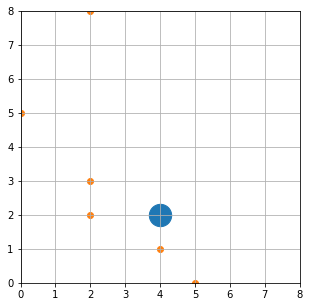

In [149]:
# this point
m = 4; n = 2
# points from previous layer
ms = [2, 4, 0, 2, 5, 2]; ns = [3, 1, 5, 8, 0, 2]
bad = calc_distances(m,n,ms,ns)

mean 2.79944854588939
mean 3.6666666666666665
mean 2.5
mean 0.19385627295595767
mean 0.75
mean 1.0


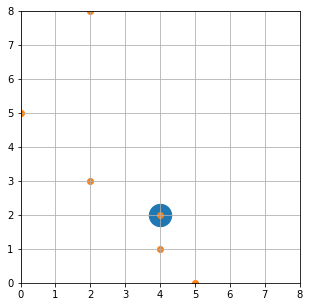

In [150]:
# this point
m = 4; n = 2
# points from previous layer
ms = [2, 4, 0, 2, 5, 4]; ns = [3, 1, 5, 8, 0, 2]
okay = calc_distances(m,n,ms,ns)

mean 1.8537362491454108
mean 2.3333333333333335
mean 1.6666666666666667
mean 0.04250090338056228
mean 0.75
mean nan


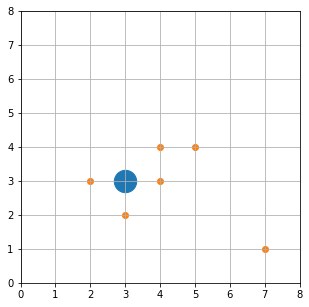

In [151]:
# this point
m = 3; n = 3
# points from previous layer
ms = [2, 5, 3, 4, 4, 7]; ns = [3, 4, 2, 4, 3, 1]
middle = calc_distances(m,n,ms,ns)

mean 1.481058252895446
mean 1.8333333333333333
mean 1.3333333333333333
mean 0.048472839822705414
mean 0.5833333333333334
mean nan


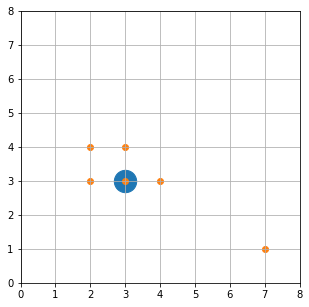

In [152]:
# this point
m = 3; n = 3
# points from previous layer
ms = [2, 2, 3, 3, 4, 7]; ns = [3, 4, 3, 4, 3, 1]
good = calc_distances(m,n,ms,ns)

mean 0.9023689270621825
mean 1.0
mean 0.8333333333333334
mean 0.018376060540885364
mean 0.5
mean nan


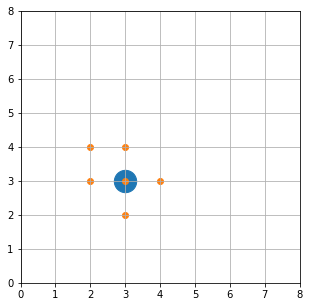

In [142]:
# this point
m = 3; n = 3
# points from previous layer
ms = [2, 2, 3, 3, 4, 3]; ns = [3, 4, 3, 4, 3, 2]
very_good = calc_distances(m,n,ms,ns)

In [153]:
n_bad = (bad - np.min(bad)) / (np.max(bad) - np.min(bad))
n_middle = (middle - np.min(middle)) / (np.max(middle) - np.min(middle))
n_good = (good - np.min(good)) / (np.max(good) - np.min(good))


all = np.array((very_bad, bad, okay, middle, good, very_good))

new_all = []
for i in range(all.shape[1]):
    print(all[:,i])
    new_all.append( (all[:,i] - np.min(all[:,i])) / (np.max(all[:,i]) - np.min(all[:,i])) )

new_all = np.array(new_all).transpose(1,0)

[7.67193045 3.13278188 2.79944855 1.85373625 1.48105825 0.90236893]
[9.66666667 4.         3.66666667 2.33333333 1.83333333 1.        ]
[7.         2.83333333 2.5        1.66666667 1.33333333 0.83333333]
[0.18170332 0.20240906 0.19385627 0.0425009  0.04847284 0.01837606]
[0.91666667 0.83333333 0.75       0.75       0.58333333 0.5       ]
[nan nan  1. nan nan nan]


In [154]:
all[1]

array([3.13278188, 4.        , 2.83333333, 0.20240906, 0.83333333,
              nan])

In [155]:
all

array([[7.67193045, 9.66666667, 7.        , 0.18170332, 0.91666667,
               nan],
       [3.13278188, 4.        , 2.83333333, 0.20240906, 0.83333333,
               nan],
       [2.79944855, 3.66666667, 2.5       , 0.19385627, 0.75      ,
        1.        ],
       [1.85373625, 2.33333333, 1.66666667, 0.0425009 , 0.75      ,
               nan],
       [1.48105825, 1.83333333, 1.33333333, 0.04847284, 0.58333333,
               nan],
       [0.90236893, 1.        , 0.83333333, 0.01837606, 0.5       ,
               nan]])

In [156]:
all.shape

(6, 6)

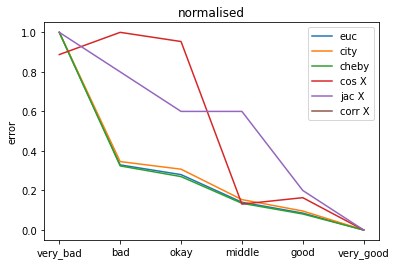

In [174]:
labels = ["euc", "city", "cheby", "cos X", "jac X", "corr X"]

plt.plot(new_all)
plt.legend(labels)
plt.title("normalised")
plt.ylabel("error")
plt.xticks(ticks= range(0,6) ,labels=["very_bad", "bad", "okay", "middle", "good", "very_good"])
plt.show()

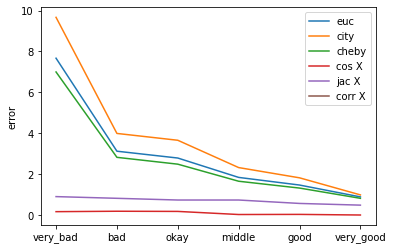

In [175]:
plt.plot(all)
plt.legend(labels)
plt.xticks(ticks= range(0,6) ,labels=["very_bad", "bad", "okay", "middle", "good", "very_good"])
plt.ylabel("error")
plt.show()

In [5]:
import numpy as np

# Create a sample 2D grid (matrix)
grid = np.array([[1, 8, 9],
                 [7, 2, 6],
                 [4, 5, 3]])

# Define the metric function (sum of values in each row)
def row_sum_metric(row):
    return np.sum(row)

# Sort the rows based on the metric
sorted_indices = np.argsort([row_sum_metric(row) for row in grid])

# Rearrange the rows in the grid based on the sorting order
sorted_grid = grid[sorted_indices]

print("Original Grid:")
print(grid)

print("\nSorted Grid based on Row Sum Metric:")
print(sorted_grid)

Original Grid:
[[1 8 9]
 [7 2 6]
 [4 5 3]]

Sorted Grid based on Row Sum Metric:
[[4 5 3]
 [7 2 6]
 [1 8 9]]


In [10]:
import numpy as np

def bubble_sort_step(grid):
    # Perform one step of Bubble Sort on the rows of the grid
    for i in range(len(grid)):
        for j in range(len(grid[0]) - 1):
            if grid[i, j] > grid[i, j + 1]:
                # Swap elements if they are in the wrong order
                grid[i, j], grid[i, j + 1] = grid[i, j + 1], grid[i, j]
    return grid

def visualize(grid):
    # Print the current state of the grid
    for row in grid:
        print(row)
    print()

# Create a sample 2D grid
grid = np.array([[8, 8, 3],
                 [6, 4, 5],
                 [3, 3, 1]])

# Number of iterations (steps) to perform the sorting
iterations = len(grid) * len(grid[0])

# Perform sorting using cellular automaton
for _ in range(iterations):
    grid = bubble_sort_step(grid)
    visualize(grid)


[8 3 8]
[4 5 6]
[3 1 3]

[3 8 8]
[4 5 6]
[1 3 3]

[3 8 8]
[4 5 6]
[1 3 3]

[3 8 8]
[4 5 6]
[1 3 3]

[3 8 8]
[4 5 6]
[1 3 3]

[3 8 8]
[4 5 6]
[1 3 3]

[3 8 8]
[4 5 6]
[1 3 3]

[3 8 8]
[4 5 6]
[1 3 3]

[3 8 8]
[4 5 6]
[1 3 3]



In [17]:
import numpy as np

def row_sum_metric(row):
    # Simple metric: Sum of values in a row
    return np.sum(row)

def update_cellular_automaton(grid, metric_function):
    new_grid = np.copy(grid)

    for i in range(1, len(grid)):
        metric_current = metric_function(grid[i])
        metric_previous = metric_function(grid[i - 1])

        if metric_current < metric_previous:
            # Swap rows if the metric is smaller in the current row
            new_grid[i] = grid[i - 1]
            new_grid[i - 1] = grid[i]

    return new_grid

def visualize(grid):
    for row in grid:
        print(row)
    print()

# Create a sample 2D grid
grid = np.array([[9, 7, 2],
                 [3, 4, 5],
                 [3, 1, 8]])

# Number of iterations (steps) to perform the rearrangement
iterations = len(grid) * len(grid[0])

# Perform rearrangement using cellular automaton
for _ in range(iterations):
    grid = update_cellular_automaton(grid, row_sum_metric)
    visualize(grid)


[3 4 5]
[9 7 2]
[3 1 8]

[3 4 5]
[3 1 8]
[9 7 2]

[3 4 5]
[3 1 8]
[9 7 2]

[3 4 5]
[3 1 8]
[9 7 2]

[3 4 5]
[3 1 8]
[9 7 2]

[3 4 5]
[3 1 8]
[9 7 2]

[3 4 5]
[3 1 8]
[9 7 2]

[3 4 5]
[3 1 8]
[9 7 2]

[3 4 5]
[3 1 8]
[9 7 2]



In [120]:

# Python3 code to demonstrate working of
# Smallest K elements indices
# using sorted() + lambda + list slicing
 
# Initialize list
test_list = [50, 6, 100, 4, 70, 1, 190]
 
# Printing original list
print("The original list is : " + str(test_list))
 
# initialize K
K = 3
 
# Smallest K elements indices
# using sorted() + lambda + list slicing
res = sorted(range(len(test_list)), key=lambda sub: test_list[sub])[K:]
 
# Printing result
print("Indices list of min K elements is : " + str(res))


The original list is : [50, 6, 100, 4, 70, 1, 190]
Indices list of min K elements is : [0, 4, 2, 6]


In [109]:
# Using sorted() + index()
# using sorted() to sort and slice K maximum elements 
temp = sorted(test_list)[-K:]
res = []
for ele in temp:
     
    # encapsulating elements with index using index()
    res.append((test_list.index(ele), ele))

# printing result 
print("K Maximum with indices : " + str(res))

K Maximum with indices : [(7, 7), (8, 8), (9, 9)]
